# EXPLORATION 6. 영화리뷰 텍스트 감성분석하기

## 1) 데이터 준비와 확인

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

import tensorflow as tf
from tensorflow import keras
import os

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
print(f'train data 개수: {len(X_train)}, test data 개수: {len(X_test)}')

train data 개수: 146182, test data 개수: 49157


In [4]:
# 사전 딕셔너리 생성
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

* get_encoded_sentence() : 하나의 문장을 이용하여, 단어를 인덱스로 변환하는 함수
* get_encoded_sentences() : 여러개의 문장을 이용하여, 단어를 인덱스로 변환하는 함수
* get_decoded_sentence() : 숫자 벡터를 원래의 문장으로 변환하는 함수
* get_decoded_sentences() : 여러개의 숫자 벡터를 원래의 여러 문장으로 변환하는 함수

## 3) 모델 구성을 위한 데이터 분석 및 가공
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [6]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))
print('10번째 리뷰 문장 길이: ', len(X_train[9]))

print(get_decoded_sentence(X_train[0], index_to_word))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17
10번째 리뷰 문장 길이:  21
더 빙 . . 진짜 짜증 나 네요 목소리


In [7]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


## 4) 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험

### LSTM (RNN : Recurrent Neural Netowrk)

In [9]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [10]:
# validation set 분리
X_val = X_train[:25000]   
y_val = y_train[:25000]

# validation set을 제외한 나머지
partial_X_train = X_train[25000:]  
partial_y_train = y_train[25000:]

print(X_val.shape)
print(y_val.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)

(25000, 41)
(25000,)
(121182, 41)
(121182,)


In [11]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
947/947 [==============================] - 8s 6ms/step - loss: 0.4212 - accuracy: 0.8097 - val_loss: 0.3475 - val_accuracy: 0.8491
Epoch 2/5
947/947 [==============================] - 5s 5ms/step - loss: 0.3272 - accuracy: 0.8602 - val_loss: 0.3461 - val_accuracy: 0.8506
Epoch 3/5
947/947 [==============================] - 5s 6ms/step - loss: 0.3052 - accuracy: 0.8709 - val_loss: 0.3397 - val_accuracy: 0.8531
Epoch 4/5
947/947 [==============================] - 5s 5ms/step - loss: 0.2858 - accuracy: 0.8789 - val_loss: 0.3354 - val_accuracy: 0.8549
Epoch 5/5
947/947 [==============================] - 5s 5ms/step - loss: 0.2645 - accuracy: 0.8890 - val_loss: 0.3414 - val_accuracy: 0.8565


In [12]:
results_lstm = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results_lstm)

1537/1537 - 3s - loss: 0.3515 - accuracy: 0.8504
[0.35148581862449646, 0.8503569960594177]


### 1-D CNN (Convolution Neural Network)

In [13]:
# 1-D CNN
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [14]:
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_cnn = model_cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
947/947 [==============================] - 6s 5ms/step - loss: 0.4058 - accuracy: 0.8106 - val_loss: 0.3375 - val_accuracy: 0.8536
Epoch 2/5
947/947 [==============================] - 4s 4ms/step - loss: 0.3028 - accuracy: 0.8720 - val_loss: 0.3325 - val_accuracy: 0.8564
Epoch 3/5
947/947 [==============================] - 4s 4ms/step - loss: 0.2571 - accuracy: 0.8951 - val_loss: 0.3428 - val_accuracy: 0.8558
Epoch 4/5
947/947 [==============================] - 4s 4ms/step - loss: 0.2101 - accuracy: 0.9188 - val_loss: 0.3745 - val_accuracy: 0.8482
Epoch 5/5
947/947 [==============================] - 4s 4ms/step - loss: 0.1667 - accuracy: 0.9388 - val_loss: 0.4173 - val_accuracy: 0.8438


In [15]:
results_cnn = model_cnn.evaluate(X_test,  y_test, verbose=2)

print(results_cnn)

1537/1537 - 2s - loss: 0.4261 - accuracy: 0.8391
[0.42614296078681946, 0.8391073346138]


### GlobalMaxPooling1D

In [16]:
# GlobalMaxPooling1D
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다.

model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gmp = model_gmp.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
947/947 [==============================] - 4s 3ms/step - loss: 0.4546 - accuracy: 0.7976 - val_loss: 0.3620 - val_accuracy: 0.8396
Epoch 2/5
947/947 [==============================] - 3s 3ms/step - loss: 0.3339 - accuracy: 0.8567 - val_loss: 0.3522 - val_accuracy: 0.8455
Epoch 3/5
947/947 [==============================] - 3s 3ms/step - loss: 0.2995 - accuracy: 0.8745 - val_loss: 0.3563 - val_accuracy: 0.8473
Epoch 4/5
947/947 [==============================] - 3s 3ms/step - loss: 0.2766 - accuracy: 0.8858 - val_loss: 0.3649 - val_accuracy: 0.8454
Epoch 5/5
947/947 [==============================] - 3s 3ms/step - loss: 0.2583 - accuracy: 0.8949 - val_loss: 0.3762 - val_accuracy: 0.8429


In [18]:
results_gmp = model_gmp.evaluate(X_test,  y_test, verbose=2)

print(results_gmp)

1537/1537 - 2s - loss: 0.3840 - accuracy: 0.8384
[0.3840039074420929, 0.8383546471595764]


## 6) Loss, Accuracy 그래프 시각화

* validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더 이상의 트레이닝은 무의미함.
* Training and validation accuracy 그래프 시각화

### LSTM

In [19]:
history_lstm_dict = history_lstm.history
print(history_lstm_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


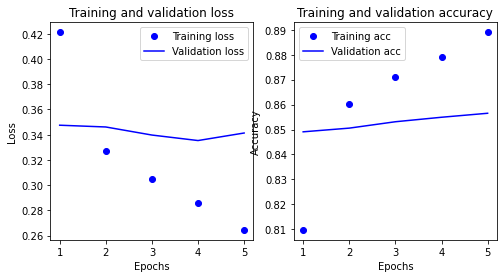

In [20]:
import matplotlib.pyplot as plt

acc = history_lstm_dict['accuracy']
val_acc = history_lstm_dict['val_accuracy']
loss = history_lstm_dict['loss']
val_loss = history_lstm_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plt.clf()   # 그림을 초기화합니다

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 1-D CNN ( Convolution Neural Network)

In [21]:
history_cnn_dict = history_cnn.history
print(history_cnn_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


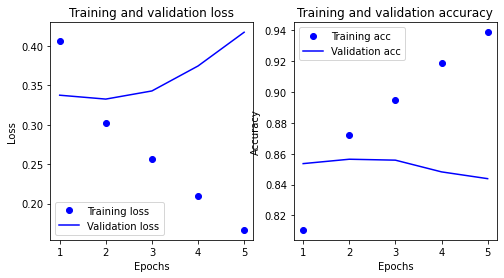

In [22]:
import matplotlib.pyplot as plt

acc = history_cnn_dict['accuracy']
val_acc = history_cnn_dict['val_accuracy']
loss = history_cnn_dict['loss']
val_loss = history_cnn_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plt.clf()   # 그림을 초기화합니다

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### GlobalMaxPooling1D

In [23]:
history_gmp_dict = history_gmp.history
print(history_gmp_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


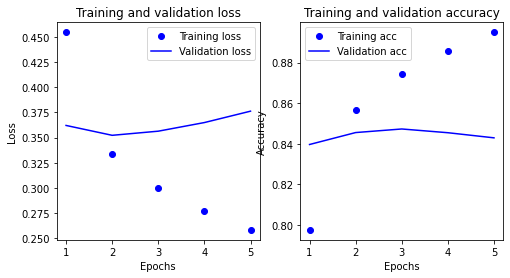

In [24]:
import matplotlib.pyplot as plt

acc = history_gmp_dict['accuracy']
val_acc = history_gmp_dict['val_accuracy']
loss = history_gmp_dict['loss']
val_loss = history_gmp_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plt.clf()   # 그림을 초기화합니다

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

In [25]:
# Word2Vec의 적용

embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [26]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [27]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['웃음']
vector

array([-0.03081841,  0.01616743, -0.02487994, -0.04259587,  0.08681718,
        0.00052077, -0.04137291, -0.01431982,  0.05466141,  0.00838809,
       -0.0049244 , -0.08618665, -0.04491316, -0.07623443,  0.00345929,
        0.00263973], dtype=float32)

In [28]:
word_vectors.similar_by_word("울음")

[('줄리안', 0.9734111428260803),
 ('팬텀', 0.9713502526283264),
 ('브라질', 0.969319224357605),
 ('시네마', 0.9682935476303101),
 ('천재', 0.9671037793159485),
 ('웰', 0.9670558571815491),
 ('부드러운', 0.9658504724502563),
 ('올릴', 0.9639681577682495),
 ('흥미진진', 0.9632986187934875),
 ('참된', 0.9622982740402222)]

* 영어로 된 Word2Vec으로는 유사한 단어를 찾기 어렵다.

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
* 한국어 Word2Vec : Pre-trained word vectors of 30+ languages
위 링크에서 적절한 ko.bin을 찾아 이용. (gensim 버전을 3.x.x로 낮춰야 오류X)

* pip uninstall gensim
* pip install gensim==3.8.3
or
* pip install --upgrade gensim==3.8.3

In [29]:
# gensim 패키지 버전 알아보기

import gensim
gensim.__version__

'3.8.3'

### 한국어 Word2Vec 임베딩 활용

In [30]:
import os
import gensim
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

vector = word2vec['명절']
vector

/tmp/ipykernel_4851/1959536968.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['명절']


array([ 6.93322241e-01, -9.50964928e-01,  4.45901036e-01,  1.69097155e-01,
        5.80301642e-01, -3.72622418e-03,  1.10867608e+00,  3.52123559e-01,
        3.93337905e-01, -7.99912140e-02,  4.19932038e-01, -1.32769847e+00,
        3.53327185e-01, -4.77027267e-01,  2.20688239e-01, -1.56747192e-01,
        3.46341252e-01,  7.66950428e-01, -1.09239051e-03, -4.10770386e-01,
        1.24586403e-01,  5.86037278e-01,  1.89526863e-02,  4.41284716e-01,
        2.16534674e-01, -3.06582659e-01,  2.52372980e-01, -2.46925771e-01,
        1.19890809e+00, -4.30984199e-01,  2.77826816e-01, -2.22586319e-01,
        3.80936742e-01,  3.15465719e-01,  1.89387977e-01, -6.79848135e-01,
        5.52557290e-01,  7.23403215e-01, -1.50069982e-01,  3.92881244e-01,
       -5.74123621e-01,  3.48875701e-01,  7.62878478e-01, -7.72131920e-01,
       -2.05789566e+00, -3.81108731e-01, -2.47676358e-01, -1.01117408e+00,
        2.71908551e-01,  4.06296819e-01,  4.25096631e-01,  4.45801049e-01,
        7.31215835e-01, -

In [31]:
word2vec.wv.most_similar("설날")

[('추석', 0.836398720741272),
 ('단오', 0.7760483622550964),
 ('명절', 0.7695590853691101),
 ('대보름', 0.7636866569519043),
 ('연휴', 0.7532376646995544),
 ('어린이날', 0.7317037582397461),
 ('섣달', 0.7061843276023865),
 ('추수', 0.6932740807533264),
 ('새해', 0.6902536749839783),
 ('휴일', 0.6774294376373291)]

In [32]:
word2vec.wv.most_similar("연휴")

[('추석', 0.8704657554626465),
 ('설날', 0.7532376050949097),
 ('휴일', 0.6423872709274292),
 ('단오', 0.6353431940078735),
 ('월요일', 0.6117392778396606),
 ('금요일', 0.6095596551895142),
 ('어린이날', 0.6063166856765747),
 ('화요일', 0.6043965816497803),
 ('일요일', 0.6042028665542603),
 ('공휴일', 0.600674033164978)]

In [33]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_4851/2286156261.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_4851/2286156261.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


### LSTM + 한국어 Word2Vec

In [34]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_lstm.add(tf.keras.layers.LSTM(128))
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [35]:
# 학습 진행
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
1894/1894 [==============================] - 13s 6ms/step - loss: 0.3922 - accuracy: 0.8205 - val_loss: 0.3244 - val_accuracy: 0.8601
Epoch 2/5
1894/1894 [==============================] - 11s 6ms/step - loss: 0.2906 - accuracy: 0.8765 - val_loss: 0.3120 - val_accuracy: 0.8652
Epoch 3/5
1894/1894 [==============================] - 11s 6ms/step - loss: 0.2465 - accuracy: 0.8976 - val_loss: 0.3155 - val_accuracy: 0.8678
Epoch 4/5
1894/1894 [==============================] - 11s 6ms/step - loss: 0.2074 - accuracy: 0.9159 - val_loss: 0.3457 - val_accuracy: 0.8658
Epoch 5/5
1894/1894 [==============================] - 11s 6ms/step - loss: 0.1683 - accuracy: 0.9329 - val_loss: 0.3655 - val_accuracy: 0.8669


In [36]:
# 테스트셋을 통한 모델 평가
results_lstm = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results_lstm)

1537/1537 - 3s - loss: 0.3739 - accuracy: 0.8619
[0.3738887310028076, 0.8618507981300354]


<Figure size 432x288 with 0 Axes>

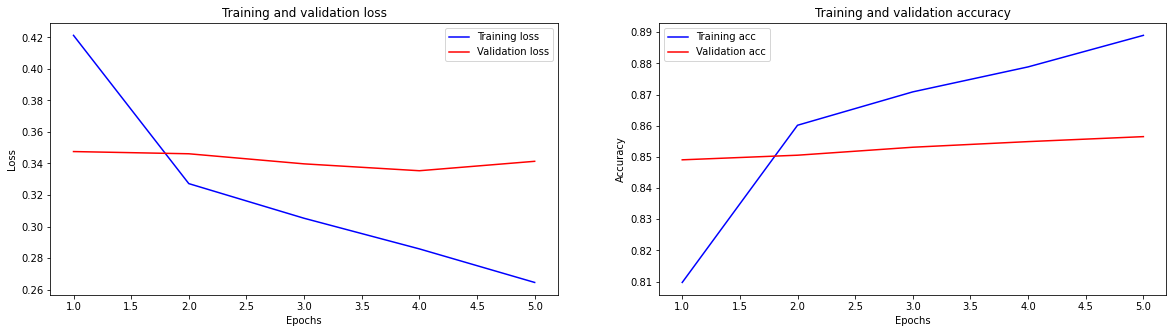

In [37]:
# 한국어 Word2Vec 임베딩 활용한 모델 그래프

history_lstm = history_lstm.history

acc = history_lstm_dict['accuracy']
val_acc = history_lstm_dict['val_accuracy']
loss = history_lstm_dict['loss']
val_loss = history_lstm_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 1-D CNN ( 1-D Convolution Neural Network)  + 한국어 Word2Vec

In [38]:
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [39]:
# 학습 진행
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_cnn = model_cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
1894/1894 [==============================] - 10s 5ms/step - loss: 0.4642 - accuracy: 0.7665 - val_loss: 0.3613 - val_accuracy: 0.8390
Epoch 2/5
1894/1894 [==============================] - 9s 5ms/step - loss: 0.3306 - accuracy: 0.8570 - val_loss: 0.3571 - val_accuracy: 0.8434
Epoch 3/5
1894/1894 [==============================] - 9s 5ms/step - loss: 0.2903 - accuracy: 0.8772 - val_loss: 0.3396 - val_accuracy: 0.8520
Epoch 4/5
1894/1894 [==============================] - 9s 5ms/step - loss: 0.2598 - accuracy: 0.8926 - val_loss: 0.3495 - val_accuracy: 0.8504
Epoch 5/5
1894/1894 [==============================] - 9s 5ms/step - loss: 0.2305 - accuracy: 0.9068 - val_loss: 0.3575 - val_accuracy: 0.8496


In [40]:
# 테스트셋을 통한 모델 평가
results_cnn = model_cnn.evaluate(X_test,  y_test, verbose=2)

print(results_cnn)

1537/1537 - 3s - loss: 0.3641 - accuracy: 0.8478
[0.36413756012916565, 0.8478344678878784]


<Figure size 432x288 with 0 Axes>

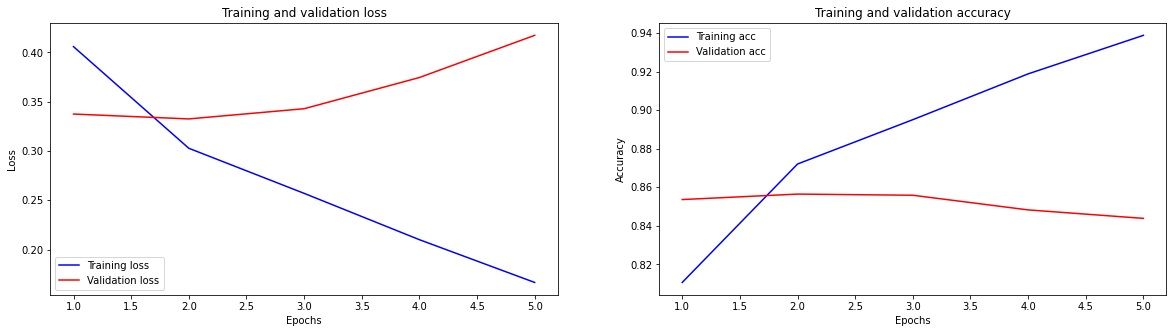

In [41]:
# 한국어 Word2Vec 임베딩 활용한 모델 그래프

history_cnn = history_cnn.history

acc = history_cnn_dict['accuracy']
val_acc = history_cnn_dict['val_accuracy']
loss = history_cnn_dict['loss']
val_loss = history_cnn_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### GlobalMaxPooling1D  + 한국어 Word2Vec

In [42]:
model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(256, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               51456     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 2,051,713
Trainable params: 2,051,713
Non-trainable params: 0
_________________________________________________________________


In [43]:
# 학습 진행
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gmp = model_gmp.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
1894/1894 [==============================] - 7s 4ms/step - loss: 0.5556 - accuracy: 0.7099 - val_loss: 0.4778 - val_accuracy: 0.7722
Epoch 2/5
1894/1894 [==============================] - 7s 4ms/step - loss: 0.4394 - accuracy: 0.7946 - val_loss: 0.4666 - val_accuracy: 0.7804
Epoch 3/5
1894/1894 [==============================] - 7s 4ms/step - loss: 0.3883 - accuracy: 0.8249 - val_loss: 0.4007 - val_accuracy: 0.8167
Epoch 4/5
1894/1894 [==============================] - 7s 4ms/step - loss: 0.3534 - accuracy: 0.8441 - val_loss: 0.4001 - val_accuracy: 0.8187
Epoch 5/5
1894/1894 [==============================] - 7s 4ms/step - loss: 0.3274 - accuracy: 0.8582 - val_loss: 0.3871 - val_accuracy: 0.8289


In [44]:
# 테스트셋을 통한 모델 평가
results_gmp = model_gmp.evaluate(X_test,  y_test, verbose=2)

print(results_gmp)

1537/1537 - 2s - loss: 0.3962 - accuracy: 0.8238
[0.3961608409881592, 0.8237890601158142]


<Figure size 432x288 with 0 Axes>

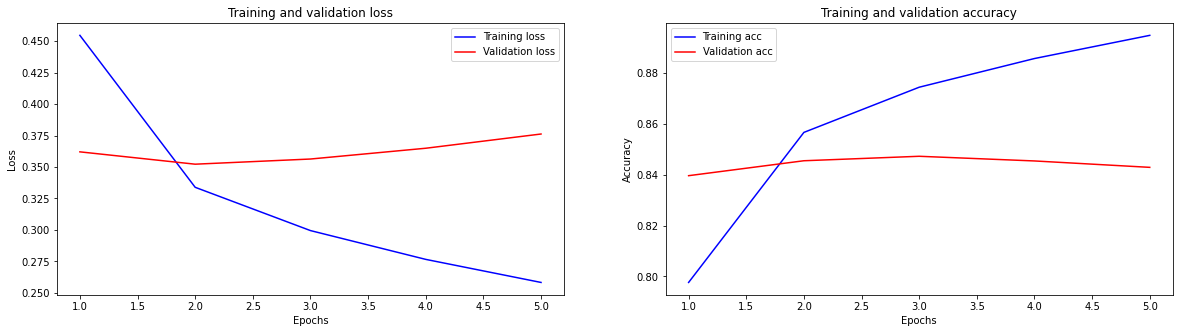

In [45]:
# 한국어 Word2Vec 임베딩 활용한 모델 그래프

history_gmp = history_gmp.history

acc = history_gmp_dict['accuracy']
val_acc = history_gmp_dict['val_accuracy']
loss = history_gmp_dict['loss']
val_loss = history_gmp_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 학습, 평가, 시각화한 3개 모델의 한국어 Word2Vec 임베딩 활용에 따른 accuracy

#### 전/후

* LSTM    0.8504 / 0.8619

* 1-D CNN    0.8391 / 0.8478

* GlobalMaxPooling1D    0.8384 / 0.8238


* LSTM 모델과 1-D CNN은 한국어 Word2Vec 임베딩 활용하여 정확도가 매우 소폭으로 향상 되었다.
* GlobalMaxPooling1D 모델은 무슨 일인지 정확도가 더 떨어졌다.

### 루브릭

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
* 3가지 이상의 모델이 성공적으로 시도됨
: LSTM, 1-D CNN, GlobalMaxPooling1D 3개 모델에 대해서 Text Classification 태스크를 구현했다.

2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
* gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함
: 자체학습된 임베딩 레이어는 유사한 단어를 잘 찾아내지 못했고, 사전학습된 임베딩은 유사한 단어를 비교적 잘 찾아냈다.

3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
* 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함
: LSTM 모델에 관해서만 정확도 85% 이상 달성했다.

### 회고

ko.bin 불러오는 부분에서부터 막혀서 당황스러웠다.
버전이 다른 경우도 처음 접해봐서 버전을 낮추는 방법에 대해서 알게되었다.

모델의 성능에 대한 시각화하는 부분에 있어서도 뭔가 부족해보이는데
좀더 알아보기 쉽게 시각화 하기 위해 공부해야 할 것 같다.

사용한 대부분의 모델들이 83~84%의 성능을 보였는데, 이게 높은 편인지 확신이 서지 않는 프로젝트였다. 한국어가 영어에 비해 복잡해서 그런지 하이퍼파라미터를 다양하게 조절해보아도 전체적으로 정확도 면에서 크게 향상 되지 않았다.
gensim의 유사단어 찾기로 보면 한국어 Word2Vec를 활용하기 전보다 활용한 후가 비교적 유사한 단어를 출력했다.
하지만 실제 네이버 영화리뷰 데이터를 넣었을 때에 어떨지 궁금하다. 실제 데이터상에는 비속어나 은어, 추상적인 표현들이 많아 분류해 낼 수 있을지 의문이다. 분류를 하더라도 신뢰할 수 있을지 확신이 서지 않다.

자연어 부분에 있어서 한국어가 제일 어렵다는 말을 간접적으로 살짝 체감한 프로젝트였다.